# Mini-Project - Nicolas Duboc

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

# Part 1

To calculate the steady state, we set $\frac{\delta T}{\delta d} = 0$ giving us the following solution: 

$$\frac{\delta}{\delta d} (A_{h} \frac{\delta T}{\delta d}) =  \frac{1}{cp} \frac{\delta I}{\delta d}$$

The solution to $\frac{\delta I}{\delta d}$ can be found by taking the derivate of I, which is described as decaying exponentially with depth with an e-folding scale of $\alpha$:

$$I = I_{0}(1-(\beta+0.1))e^{-d/\alpha}$$

$$\frac{\delta I}{\delta d} = -\frac{I_{0}(1-(\beta+0.1))e^{-d/\alpha}}{\alpha} $$

Where $\beta$ is the ice fraction and 0.1 is the water surface albedo both of which contribute to the fractional light energy at the surface.

Aside from out initial conditions at the surface (-1C) and 200m (-2C), $\frac{1}{cp} \frac{\delta I}{\delta d}$ can be evaluated at every depth. We can then use the midpoint method to approximate $\frac{\delta}{\delta d} (A_{h} \frac{\delta T}{\delta d})$ at every half step: 

$$\frac{\delta}{\delta d} (A_{h} \frac{\delta T}{\delta d}) = \frac{\delta}{\delta d} (A_{hi} \frac{\delta T_{i+\frac{1}{2}}-T_{i+\frac{1}{2}} }{\delta d}) $$

Now we can approximate this outer derivative with another half step, allowing us to evaluate $T$ at every whole step and $A_{h}$ at every half step:

$$\frac{\delta}{\delta d} (A_{hi}\frac{T_{i+\frac{1}{2}}}{\delta d}) - \frac{\delta}{\delta d} (A_{hi}\frac{T_{i-\frac{1}{2}}}{\delta d}) $$

$$\frac{A_{hi+\frac{1}{2}}T_{i+1} - A_{hi-\frac{1}{2}}T_{i} - A_{hi+\frac{1}{2}}T{i} -A_{hi-\frac{1}{2}}T_{i-1}}{\delta d^{2}} $$

Combining terms gives us the following coefficients for $T_{i+1}$, $T_{i}$, and $T_{i-1}$:

$$T_{i+1}(A_{hi+\frac{1}{2}}) - T_{i}(A_{hi+\frac{1}{2}}+A_{hi-\frac{1}{2}}) + T_{i-1}(A_{hi-\frac{1}{2}}) $$

These coefficients are then inserted in matrix A, where we can use the $\frac{\delta I}{\delta d}$ evaluated at every depth to solve for the temperature profile at every depth:

$$AT = F$$
$$T = A^{-1}F$$

In [2]:
def deriv_I(d,alpha,beta):
    Io = 100*(1-(beta+0.1))
    return -(Io*np.exp(-d/alpha))/alpha

def deriv_Ah(depth,h,Ah):
    A_max = Ah[0]
    A_depth = Ah[1]
    A_dip = Ah[2]
    if depth < h:
        return A_max
    else:
        return  np.abs(A_depth + (A_max-A_depth-A_dip*(depth-h))*np.exp(-0.5*(depth-h)))
    
def n_matrix(N,h,Ah):
    A = np.zeros(shape=(N+1,N+1))

    # Evaluated d/dd[Ah dT/dd] as a whole (check notes)
    for i in range(1,N):
        z1 = deriv_Ah(i-0.5,h,Ah) 
        z2 = (deriv_Ah(i+0.5,h,Ah) + deriv_Ah(i-0.5,h,Ah))
        z3 = deriv_Ah(i+0.5,h,Ah) 
        A[i,i-1:3+(i-1)] = [z1,-z2,z3]
    return A 


In [3]:
N = 200 # total depth
h = 10 # mixing layer depth 
Ah = [[1e-2,1e-4,1.5e-3],
     [2e-2,2e-4,2.5e-3],
     [1e-3,2e-5,2.5e-4]]
alpha = [10,20,30]
beta = [0.2,0.5,0.8]
cp = 4e6

T = np.zeros(shape=(N+1,3,3,3))

for i in range(3):
    for j in range(3):
        for k in range(3):
            A = n_matrix(N,h,Ah[k])
            
            # Setting up initial conditions
            A[0,0] = 1 
            A[-1,-1] = 1 
        
            F = np.zeros(N+1).reshape((N+1),1)
            F[0] = -1 
            F[-1] = -2
            
            for d in range(1,N):
                F[d] = (1/cp * deriv_I(d,alpha[i],beta[j]))
            
            T[:,i,j,k] = np.linalg.solve(A,F)[:,0]


In [4]:
depth = np.arange(T.shape[0])

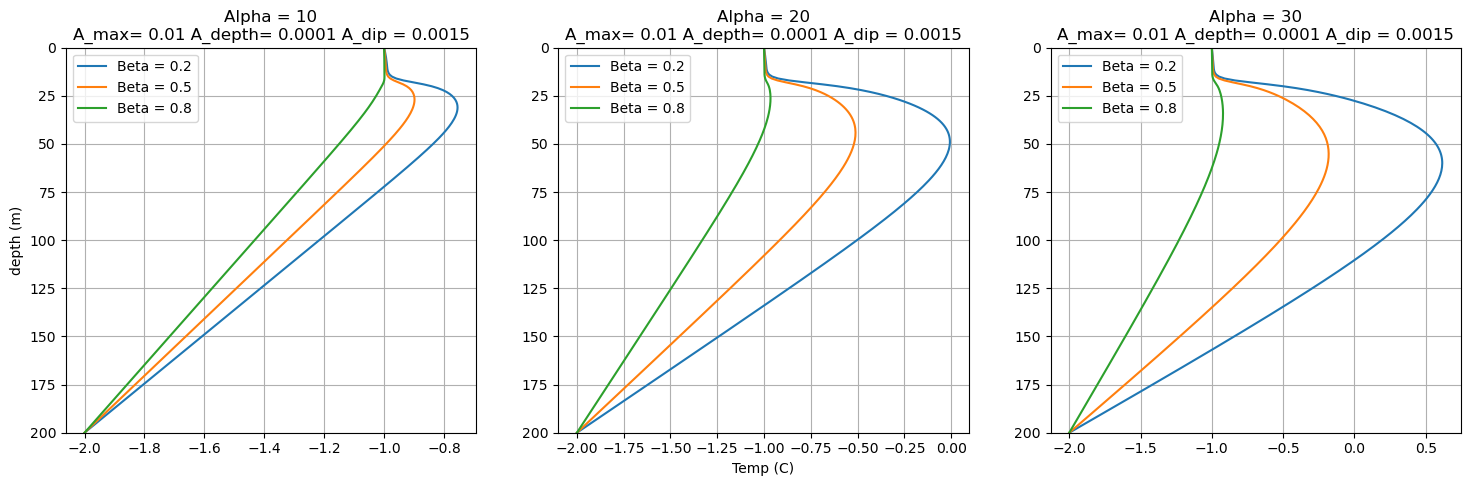

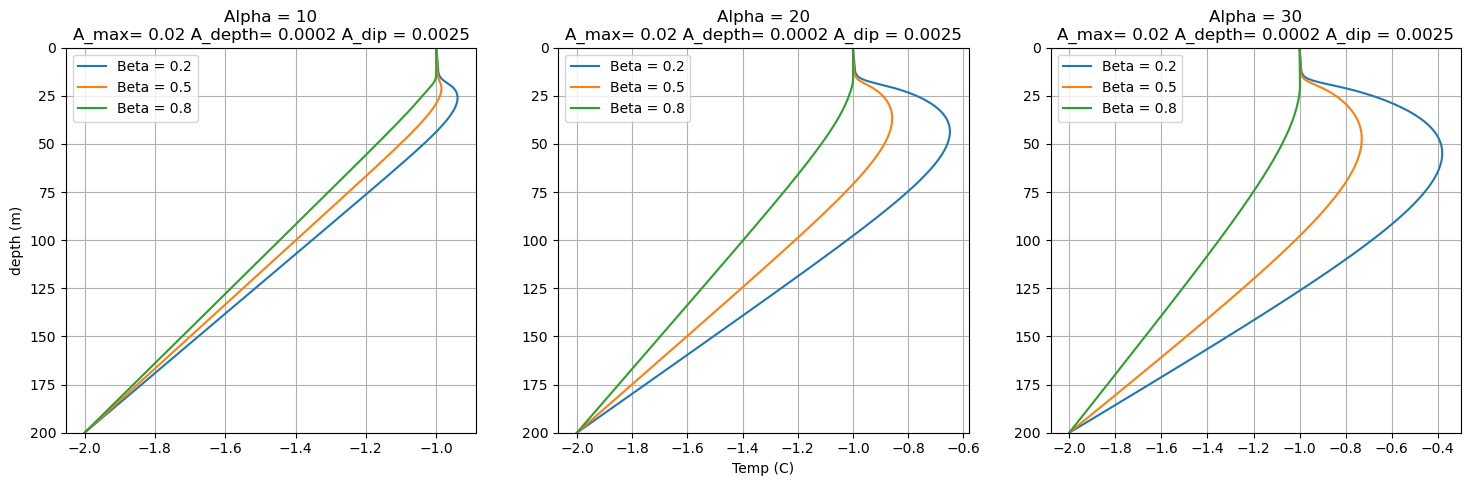

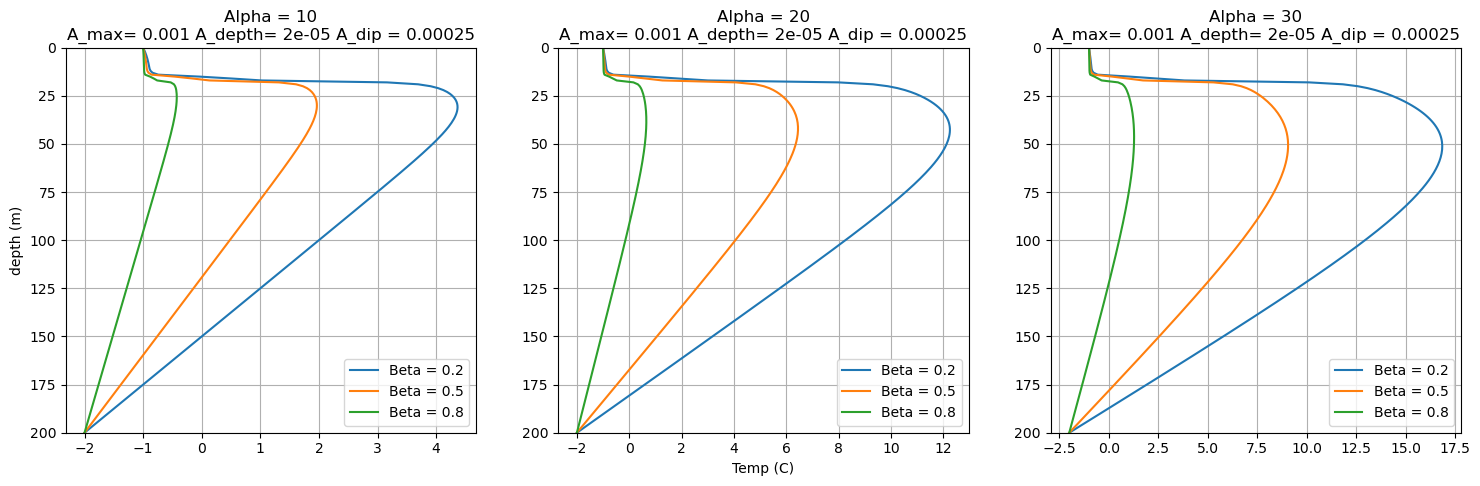

In [5]:
for i in range(3):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
    
    ax1.plot(T[:,0,0,i],depth,label=f'Beta = {beta[0]}') 
    ax1.plot(T[:,0,1,i],depth,label=f'Beta = {beta[1]}') 
    ax1.plot(T[:,0,2,i],depth,label=f'Beta = {beta[2]}') 
    ax1.set_title(f'Alpha = {alpha[0]}\nA_max= {Ah[i][0]} A_depth= {Ah[i][1]} A_dip = {Ah[i][2]}')
    ax1.set_ylabel('depth (m)')
    ax1.set_ylim(200,0)
    ax1.legend(loc='best')
    ax1.grid()
    
    ax2.plot(T[:,1,0,i],depth,label=f'Beta = {beta[0]}') 
    ax2.plot(T[:,1,1,i],depth,label=f'Beta = {beta[1]}') 
    ax2.plot(T[:,1,2,i],depth,label=f'Beta = {beta[2]}') 
    ax2.set_title(f'Alpha = {alpha[1]}\nA_max= {Ah[i][0]} A_depth= {Ah[i][1]} A_dip = {Ah[i][2]}')
    ax2.set_xlabel('Temp (C)')
    ax2.set_ylim(200,0)
    ax2.legend(loc='best')
    ax2.grid()

    ax3.plot(T[:,2,0,i],depth,label=f'Beta = {beta[0]}') 
    ax3.plot(T[:,2,1,i],depth,label=f'Beta = {beta[1]}') 
    ax3.plot(T[:,2,2,i],depth,label=f'Beta = {beta[2]}') 
    ax3.set_title(f'Alpha = {alpha[2]}\nA_max= {Ah[i][0]} A_depth= {Ah[i][1]} A_dip = {Ah[i][2]}')
    ax3.set_ylim(200,0)
    ax3.legend(loc='best')
    ax3.grid()

The plots above show 3 different scenarios with different values for $A_h$, $\beta$, and $\alpha$. The first thing to note is the reduction in heating below the mixing layer for different values of $\beta$. As $\beta$ gets larger, the amount of attenuated light energy is reduced due to the increased ice coverage. This causes a reduction in heating just below the surface layer and can be seen by the different curves in each plot. From left to right, as $\alpha$ gets larger, our e-folding scale gets larger due to $e^{-d/\alpha}$. This causes the exponential decay of light energy to be less, which allows for more of the light energy to penetrate through the surface and warming the layer below the mixing layer.

# Part 2
Using the first set of parameters for all scenarios:
- $\beta = 0.5$
- $A_{max} = 10^{-2}$
- $A_{depth} = 10^{-4}$
- $A_{dip} = 1.5 * 10^{-3}$
- $\alpha = 10$

In [6]:
# Initialize first set of paramters
A = n_matrix(N,h,Ah[0])
A[0,0] = 1 
A[-1,-1] = 1 
F = np.zeros(N+1).reshape((N+1),1)
F[0] = -1 
F[-1] = -2
for d in range(1,N):
    F[d] = (1/cp * deriv_I(d,alpha[0],beta[0]))
T = np.linalg.solve(A,F)
T1 = np.linalg.solve(A,F)
T2 = np.linalg.solve(A,F)
T3 = np.linalg.solve(A,F)

In [7]:
def deriv_T(A,T,F):
    return np.matmul(A,T)-F

## Scenario 1 - Steady State as initial condition

In [8]:
Ntime = 500 # seconds
dt = 10 # seconds 
timeVec1 = np.arange(0,Ntime,dt)

Tn = []
T1 = T
for i in range(len(timeVec1)):
    Tnew = T1 + dt*(deriv_T(A,T1,F))
    Tn.append(Tnew)
    T1 = Tnew
Tn = np.array(Tn)

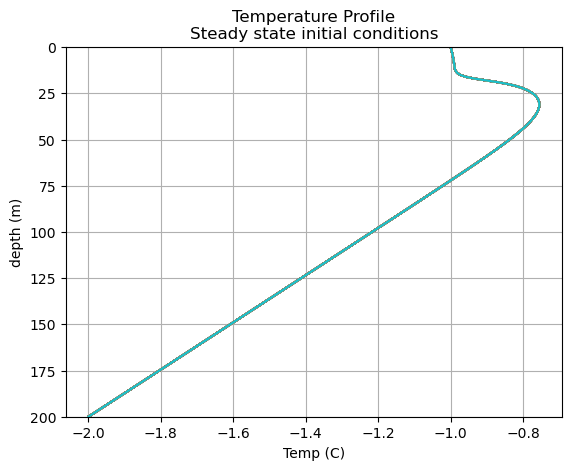

In [9]:
for i in range(np.shape(Tn)[0]):
    plt.plot(Tn[i,:],depth,label=i+1)
plt.ylim(200,0)
plt.xlabel('Temp (C)')
plt.ylabel('depth (m)')
plt.title('Temperature Profile\nSteady state initial conditions')
plt.grid()

The plot above depicts the evolution of the temperature profile for 200 seconds and a timestep of 10 seconds. The blue curve indicates the first time step and the teal indicates the last time step. Given that there is no change in the temperature profile due to the use of the steady state as our initial conditions, the lines are overlapped on one another.

**What happens during the inital timesteps**

No change in the temperature profile. This is consistent with using the steady state solutions as our initial conditions. Since the derivative of Ah and T was calculated using this steady state solution, any step forward will result in the derivative being zero and therefore returning the initial condition for every timestep.

**What happens as the system approaches a new equilibirum**

The system stays in equilibrium because we are using the steady state solution as our initial condition for the reasons listed above. The derivative is zero, due to the equation being in steady state. 

**Whether these simulations conserve energy, how can you tell. If not, why not - where is energy being lost or gained, and why?**

System stays in equilibrium, and therefore conserves its energy. There is no change in the temperature profile with time. 

## Scenario 2 - Warming in the first 5 layers

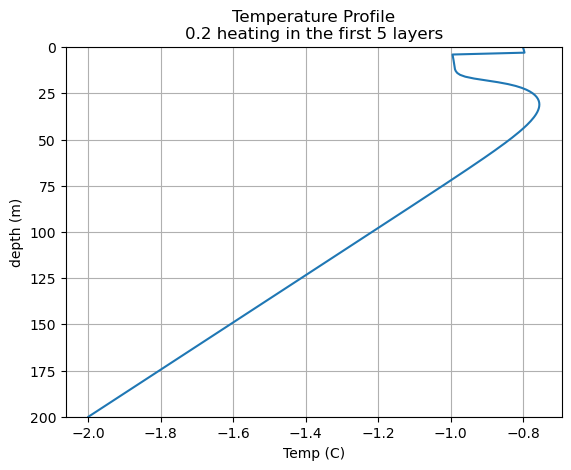

In [10]:
T2[:4] = T2[:4]+0.2
plt.plot(T2,depth)
plt.ylim(200,0)
plt.xlabel('Temp (C)')
plt.ylabel('depth (m)')
plt.title('Temperature Profile\n0.2 heating in the first 5 layers')
plt.grid()

In [11]:
Tn_surf_heat = []
for i in range(len(timeVec1)):
    Tnew = T2 + dt*deriv_T(A,T2,F)
    Tnew[0] = Tnew[1]
    Tnew[-1] = Tnew[-2]
    Tn_surf_heat.append(Tnew)
    T2 = Tnew
Tn_surf_heat = np.array(Tn_surf_heat)

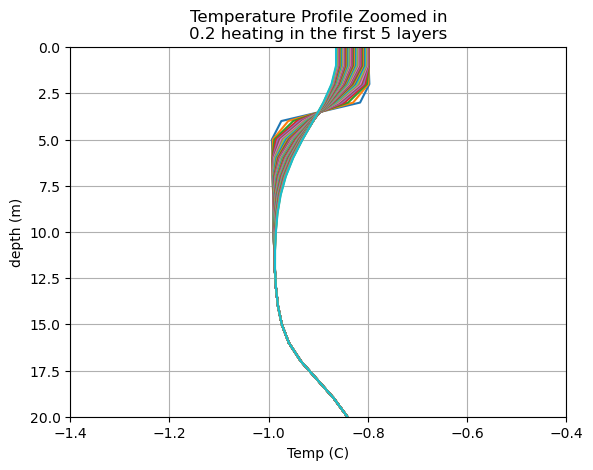

In [12]:
for i in range(np.shape(Tn_surf_heat)[0]):
    plt.plot(Tn_surf_heat[i,:],depth,label=i+1)
plt.ylim(20,0)
plt.xlim(-1.4,-0.4)
plt.xlabel('Temp (C)')
plt.ylabel('depth (m)')
plt.title('Temperature Profile Zoomed in\n0.2 heating in the first 5 layers')
plt.grid()

The plot above is a zoomed in version of the first plot presented in Scenario 2. The dark blue curve represents our initial condition, a heating of 0.2 degrees within the first 5 layers of the ocean. The teal curve is the final state and the alternating colors in between these two curves represent the profile at different time steps leading up to this final state. 

**What happens during the inital timesteps**

During the first inital time steps, the system tries to equalize itself by both cooling the heated layer and warming the layer below it. The inital temperature profiles don't have as big a difference within the first few timesteps. This can be seen by the orange curve; the temperature deviates slightly from the initial condition (-0.8 in the heated layer and -1 in the mixed layer below it) but ultimately continues to follow the inital temperature profile.


**What happens as the system approaches a new equilibirum**

As the system approaches a new equilibrium the cooling in the warmed layer and warming in the layer below it becomes greater. The subsequent rainbow of curves seen on the plot depict how the profile deviates from its initial condition to reach a new equilibrium. These temperatures in the profile changes about a centered point at  $\approx 3.5$ meters, where the temperature stays relatively constant in time.

**Whether these simulations conserve energy, how can you tell. If not, why not - where is energy being lost or gained, and why?**

No energy is lost to the environment as the temperature in the warmed layer cools and the layer below it warms. The heat that was gained initially distributes itself in the column and gives a warmer profile than that seen in the non-heating scenario.

## Scenario 3 - Warming between 150 and 160 meters

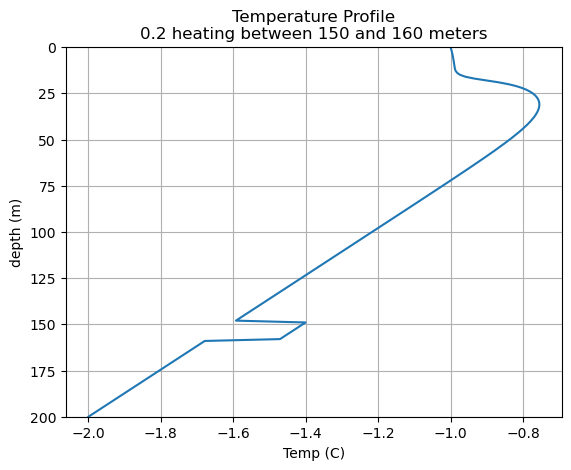

In [13]:
T3[149:159] = T3[149:159]+0.2
plt.plot(T3,depth)
plt.ylim(200,0)
plt.xlabel('Temp (C)')
plt.ylabel('depth (m)')
plt.title('Temperature Profile\n0.2 heating between 150 and 160 meters')
plt.grid()


In [14]:
Ntime = 50000 # seconds
dt = 10 # seconds 
timeVec2 = np.arange(0,Ntime,dt)
#deriv_T = np.dot(A,T)-F

In [15]:
Tn_bot_heat = []
for i in range(len(timeVec2)):
    Tnew = T3 + dt*deriv_T(A,T3,F)
    Tnew[0] = Tnew[1]
    Tnew[-1] = Tnew[-2]
    Tn_bot_heat.append(Tnew)
    T3 = Tnew
Tn_bot_heat = np.array(Tn_bot_heat)

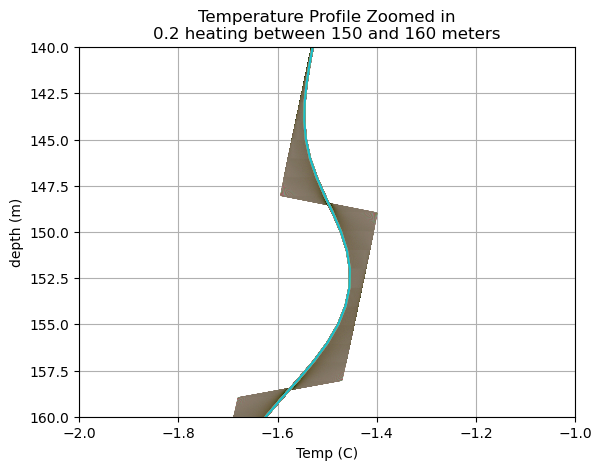

In [16]:
for i in range(np.shape(Tn_bot_heat)[0]):
    plt.plot(Tn_bot_heat[i,:],depth,label=i+1)
plt.ylim(160,140)
plt.xlim(-2,-1)
plt.xlabel('Temp (C)')
plt.ylabel('depth (m)')
plt.title('Temperature Profile Zoomed in\n0.2 heating between 150 and 160 meters')
plt.grid()

# plt.ylim(200,0)
#plt.legend(loc='best')

The plot above depicts a zoomed in version of the warming found in the bottom layer between 150 and 160 meters. The outline of the brown shaded area around the teal curve represents the initial temperature profile. Since the simulation needed to be run for several orders of magnitude longer than Scenario 2, the subsequent temperature profiles for each timestep are overlayed very close to one another, making the transition from inital state to equilibrium look like a solid polygon. The final timestep can be seen by the teal curve. 

As mentioned above, the simulation needed to be run for several orders of magnitude longer than Scenario 2, this is because this bottom layer is much more stratified than the top mixing layer. Therefore, the temperature profile will need a significantly longer time to distribute heat among the layers before it reaches an equilibrium. However, its important to note that there is a point where the maximum heat does not change as quickly with time as the depths where there is an abrupt change in temperature profile. 


**What happens during the inital timesteps**

Similarly to Scenario 2, the inital timesteps depict the temperature profile slightly warming above and below the warmed layer, and vice versa within the warm layer. During the initial time step, change is very gradual; the temperatures vary slightly from the initial condition. As the temperature profile continues to change to a more gaussian distribution, the maximum amount of heating changes very slightly.


**What happens as the system approaches a new equilibirum**

As this system reaches a new equilibrium, the cooler layers warm and the warmer layers cool in a gaussian shape. This distribution of heat energy has a maximum that changes only very slightly throughout the duration of the simulation. 

**Whether these simulations conserve energy, how can you tell. If not, why not - where is energy being lost or gained, and why?**

The simulation continues to conserve energy as the heat is distributed to layers slightly above and below 150 and 160, warming those layers while simultanioously cooling the heated layer. Eventually, reaching an equilibrium that is different from before the layer warmed.
